## TauRunner

Welcome to the TauRunner tutorial! This software is capable of simulating neutrinos (and anti-neutrinos) of all flavors, accounting for tau regeneration and losses in the nutau channel. The output is a set of particle energies, number of interactions, angle, and particle type.

The user has the option to propagate:
1. monochromatic fluxes
2. power-law fluxes
3. Any provided arbitrary flux by means of sampling from a cdf. 

All of these can be propagated through either:
1. a fixed angle
2. a range of angles
3. uniformly sampled angles in the sky. 

In terms of astrophysical bodies, we provide implementations for the Earth and Sun with capabilities of adding additional layers and changing the detector depth. In addition, we will demonstrate how to define any astrophysical object, or a slab of constant density to propagate through. All of these capabilities will be shown in the following examples. Happy running!

In [6]:
from taurunner.main import run_MC
from taurunner.cross_sections import CrossSections
from taurunner.body import Body
#earth creator function lumen_sit()
from taurunner.body.earth import lumen_sit

from taurunner.utils import make_initial_e
from taurunner.utils import make_initial_thetas
from taurunner.utils import make_propagator
from taurunner.utils.make_tracks import make_tracks

import proposal as pp
import numpy as np

## Example 1: Monochromatic flux through single angle in Earth ##

In [14]:
nevents = 10000                    #number of events to simulate
eini    = 1e19                     #intial energy in eV
theta   = np.radians(89.0)         #initial incidence angle (nadir) in radians
pid = 16                           #particle id according to the PDG MC Encoding (nutau)
xs_model = 'CSMS'                  #neutrino cross section and 
                                   #corresponding tau loss model choice

TR_specs = {                       #TR_specs contains a summary of params
    'energy': eini,
    'theta': theta,
    'flavor': pid,
    'no_secondaries': False,
    'nevents': nevents,
    'seed': 7,
    'xs_model': xs_model,
    'no_losses': False,
    'track': 'chord',
    'depth': 0.0,
    }

Earth = lumen_sit(layers=[(4, 1.0)])      #Make Earth object with 4km ice layer
xs    = CrossSections(xs_model)    #Make cross section object
energies = np.ones(nevents)*eini
thetas   = np.ones(nevents)*theta

tracks = make_tracks(TR_specs, thetas, Earth.radius)
tau_prop = make_propagator(pid, Earth)
rand = np.random.RandomState(seed=7)

output = run_MC(energies, thetas, Earth, xs, tracks, TR_specs, tau_prop, rand)

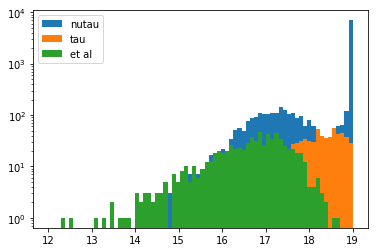

In [15]:
import matplotlib.pyplot as plt

bins  = np.linspace(12, 19, 75)
zeros = output['Eout']==0.
nutau_mask = np.logical_and(output['PDG_Encoding']==16, ~zeros)
tau_mask  = np.logical_and(np.abs(output['PDG_Encoding'])==15, ~zeros)
et_al = np.logical_and(~zeros, np.logical_and(~nutau_mask, ~tau_mask))

hn = plt.hist(np.log10(output['Eout'][nutau_mask]), bins=bins, label='nutau')
ht = plt.hist(np.log10(output['Eout'][tau_mask]), bins=bins, label='tau')
ho = plt.hist(np.log10(output['Eout'][et_al]), bins=bins, label='et al')
plt.legend()
plt.semilogy()
plt.show()

[]

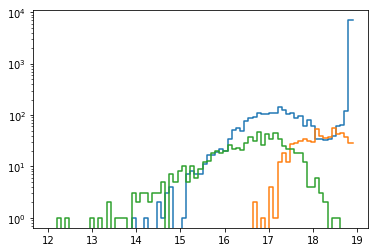

In [17]:
plt.step(hn[1][:-1], hn[0], where='pre')
plt.step(ht[1][:-1], ht[0], where='pre')
plt.step(ho[1][:-1], ho[0], where='pre')
plt.semilogy()


In [ ]:
# set up neutrino MC
n_events = 1000
en = 1e10
theta = 0.0
seed = 2
xs_model = 'dipole'

TR_specs = {
    'energy': en,
    'theta': theta,
    'flavor': 15,
    'no_secondaries': True,
    'nevents': num_sim,
    'seed': seed,
    'xs_model': xs_model,
    'no_losses': False
    }

rand = np.random.RandomState(TR_specs['seed'])
TR_specs['rand'] = rand

eini = make_initial_e(TR_specs, rand=rand)
thetas = make_initial_thetas(TR_specs, rand=rand)
track  = Chord(theta=theta, depth=0.)
#make cross section object
xs = CrossSections(TR_specs['xs_model'])

#propagate taus in water
atmosphere = Body(1.0, 1e9)
#bod        = lumen_sit()
prop = make_propagator(16, atmosphere)
proposal_lep           = pp.particle.DynamicData(pp.particle.TauMinusDef().particle_type)
proposal_lep.position  = pp.Vector3D(0, 0, 0)
proposal_lep.direction = pp.Vector3D(0, 0, 1)

tau_out = []
for ein in eini:
    this_tau = particle.Particle(15, ein, 0., 0., 0, xs, prop, False, False)
    this_tau.PropagateChargedLepton(atmosphere, track)
    #energy at decay in eV, distance to decay in km
    tau_out.append([this_tau.energy, this_tau.chargedposition])